In [4]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import shap
import lime

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
                                nn.ReLU(),
                                nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv1(x_cat)
        return self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        out = x * self.ca(x)
        out = out * self.sa(out)
        return out

# --- ResNet Building Blocks (No Change) ---

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# --- Customizable ResNet Model Definition with Attention (No Pre-built Architectures) ---

class CustomResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1, add_attention=True,
                 zero_init_residual=False, groups=1, width_per_group=64,
                 replace_stride_with_dilation=None, norm_layer=None):
        """
        Customizable ResNet architecture.

        Args:
            block (nn.Module): Type of building block (e.g., BasicBlock or Bottleneck).
            layers (list): A list of integers indicating the number of blocks in each of the 4 stages.
                           Example: [2, 2, 2, 2] for ResNet18, [3, 4, 6, 3] for ResNet50.
            num_classes (int): Number of output classes for the final classification layer.
            add_attention (bool): Whether to add CBAM attention modules after each stage.
            zero_init_residual (bool): If True, zero-initialize the last BN in each
                                       residual branch, so that the residual branch starts
                                       with zeros, and each residual block behaves like an identity.
                                       This improves the accuracy of the model at the beginning of training.
            groups (int): Number of blocked connections from input channels to output channels.
            width_per_group (int): Base width of the output channels for each group.
            replace_stride_with_dilation (list, optional): If not None, a list of booleans
                                                            indicating whether to replace
                                                            the 2x2 stride with a dilated
                                                            convolution in stages 2, 3, and 4.
            norm_layer (callable, optional): Normalization layer to use (default: BatchNorm2d).
        """
        super(CustomResNet, self).__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet stages (layers)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])

        # Final pooling and classification layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.dropout = nn.Dropout(p=0.5)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

        # Attention modules
        self.add_attention = add_attention
        if self.add_attention:
            # CBAM modules are instantiated based on the output channels of each layer
            self.cbam1 = CBAM(64 * block.expansion)
            self.cbam2 = CBAM(128 * block.expansion)
            self.cbam3 = CBAM(256 * block.expansion)
            self.cbam4 = CBAM(512 * block.expansion)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        if self.add_attention:
            x = self.cbam1(x)

        x = self.layer2(x)
        if self.add_attention:
            x = self.cbam2(x)

        x = self.layer3(x)
        if self.add_attention:
            x = self.cbam3(x)

        x = self.layer4(x)
        if self.add_attention:
            x = self.cbam4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.dropout(x)
        return x


In [7]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    return epoch_loss, epoch_accuracy

# --- Validation Loop ---
def validate_epoch(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    return epoch_loss, epoch_accuracy


# --- Test Loop ---
def test_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation for testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    test_loss = running_loss / total_samples
    test_accuracy = correct_predictions / total_samples
    return test_loss, test_accuracy


In [8]:
# Setup
num_classes = 2  # Example: for CIFAR-10, change if your task is different
epochs = 20
batch_size = 128
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model (e.g., a ResNet-18 with attention)
model = CustomResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, add_attention=True).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Modifica questo con il percorso alla tua cartella
data_dir = "/content/drive/MyDrive/SL_Project/binary_one_type_split"

# Dimensione standard, modificabile
image_size = 256

# Trasformazioni da applicare: resize, tensorizzazione e normalizzazione
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),  # converte in [0,1]
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # per 3 canali
])

# Dataset completo dalla cartella di training
full_train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)

# Definisci le percentuali per train e validation
train_size = int(0.8 * len(full_train_dataset)) # 80% per il training effettivo
val_size = len(full_train_dataset) - train_size # 20% per la validation

# Split del dataset di training in train e validation sets
# Per riproducibilità dello split
g = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size], generator=g)

# DataLoader per batch
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False) # Shuffle False for val
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False) # Shuffle False for test

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 2416
Validation dataset size: 604
Test dataset size: 755


In [10]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

for epoch in range(epochs):
    train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate_epoch(model, val_loader, criterion, device)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0

    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping at epoch {epoch+1}!")
            break

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"   Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
    print(f"   Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

print("\nTraining complete.")



# --- Test Loop ---
test_loss, test_accuracy = test_model(model, test_loader, criterion, device)
print(f"\nTest Results:")
print(f"   Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")


Using device: cuda
Epoch 1/20:
   Train Loss: 0.3163, Train Acc: 0.8311
   Val Loss: 1.4848, Val Acc: 0.5629
Epoch 2/20:
   Train Loss: 0.2520, Train Acc: 0.8580
   Val Loss: 1.0622, Val Acc: 0.5679
Epoch 3/20:
   Train Loss: 0.2228, Train Acc: 0.8601
   Val Loss: 0.1315, Val Acc: 0.9470
Epoch 4/20:
   Train Loss: 0.1980, Train Acc: 0.8605
   Val Loss: 0.1859, Val Acc: 0.9387
Epoch 5/20:
   Train Loss: 0.1841, Train Acc: 0.8642
   Val Loss: 0.0913, Val Acc: 0.9702
Epoch 6/20:
   Train Loss: 0.1818, Train Acc: 0.8634
   Val Loss: 0.0646, Val Acc: 0.9834
Epoch 7/20:
   Train Loss: 0.1736, Train Acc: 0.8717
   Val Loss: 0.0644, Val Acc: 0.9818
Epoch 8/20:
   Train Loss: 0.1902, Train Acc: 0.8605
   Val Loss: 0.1601, Val Acc: 0.9454
Epoch 9/20:
   Train Loss: 0.1963, Train Acc: 0.8622
   Val Loss: 0.2087, Val Acc: 0.9238
Epoch 10/20:
   Train Loss: 0.2150, Train Acc: 0.8535
   Val Loss: 0.1624, Val Acc: 0.9454
Epoch 11/20:
   Train Loss: 0.2031, Train Acc: 0.8630
   Val Loss: 0.1142, Val A

In [11]:
torch.save(model.state_dict(), 'attention_resnet.pth')

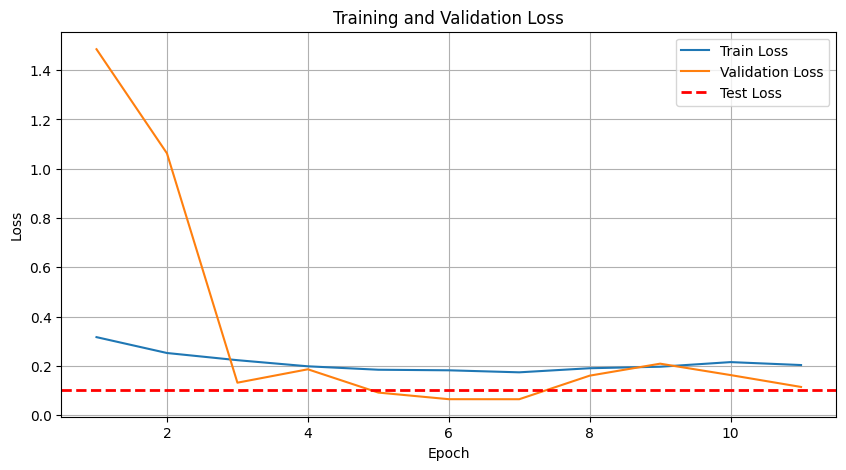

In [13]:
# --- Plotting ---
epochs_range = range(1, epoch + 1)

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.axhline(y=test_loss, color='red', linestyle='--', linewidth=2, label = 'Test Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

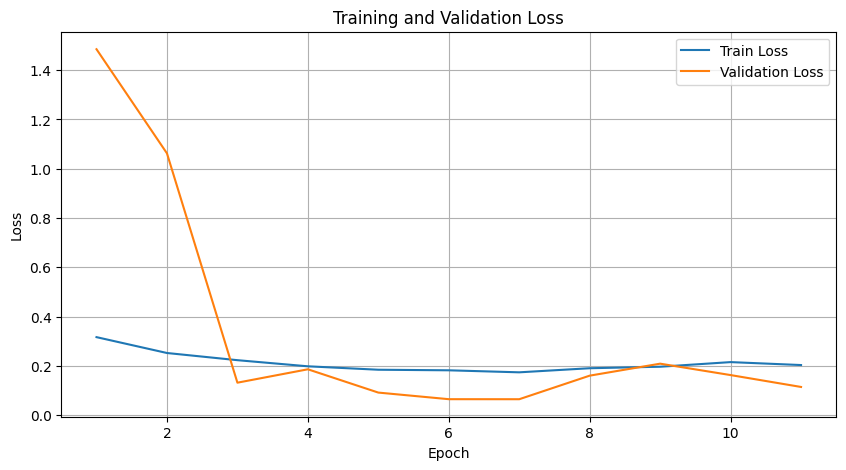

In [14]:
# --- Plotting ---
epochs_range = range(1, epoch + 1)

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

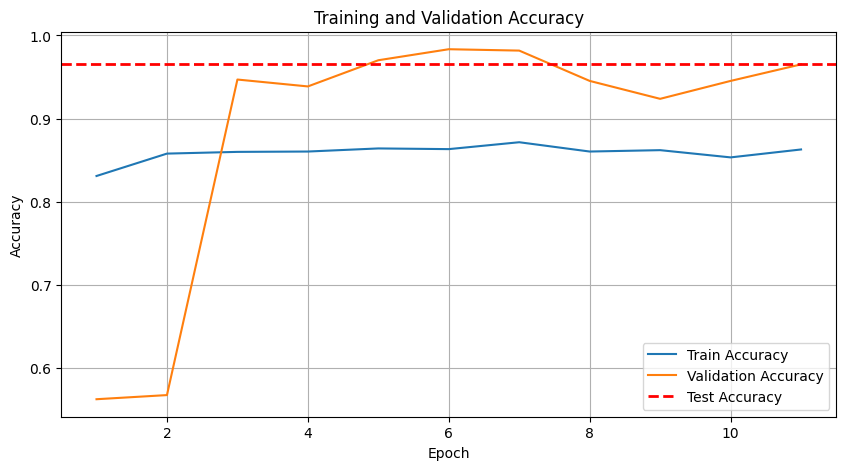

In [16]:
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='red', linestyle='--', linewidth=2, label = 'Test Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

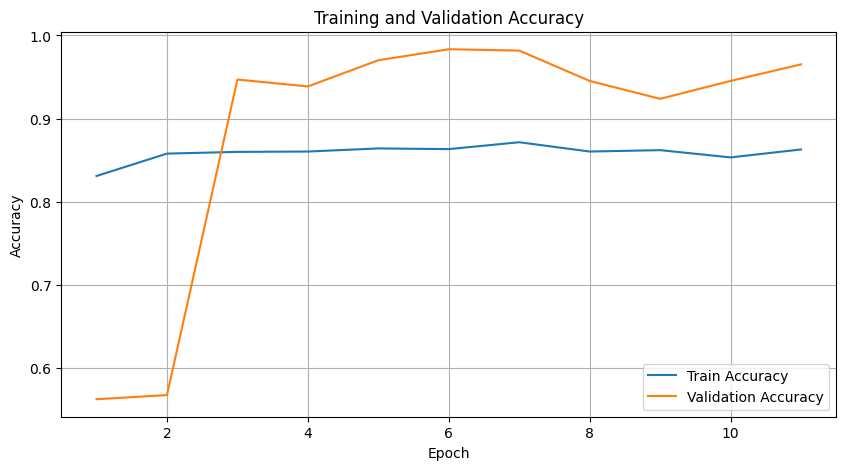

In [17]:
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self._save_activations)
        self.target_layer.register_backward_hook(self._save_gradients)

    def _save_activations(self, module, input, output):
        self.activations = output

    def _save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, input_image, target_class=None):
        self.model.eval()
        output = self.model(input_image)
        if target_class is None:
            # For binary classification, you typically want the CAM for the predicted class
            # For a single sigmoid output, if output > 0.5, target class is 1, else 0
            # For CrossEntropyLoss, torch.argmax(output) gives the predicted class
            if self.model.fc.out_features == 1: # Binary classification with sigmoid output or raw logit
                 # For binary output (logit), the prediction is based on the sign
                 predicted_class = (output.item() > 0).long() # Get the single logit and compare
                 target_class = predicted_class.item()
            else: # Multi-class classification
                 target_class = output.argmax(dim=1).item()

        # Zero gradients
        self.model.zero_grad()

        # Backward pass for the target class
        # If output is a single logit (num_classes=1), target_class won't be used directly for indexing
        # For a single output (binary classification), you backpropagate on the output itself.
        if self.model.fc.out_features == 1:
            # Backpropagate on the single output logit
            output.backward(gradient=torch.ones_like(output), retain_graph=True)
        else:
            one_hot_output = torch.zeros_like(output)
            one_hot_output[0][target_class] = 1
            output.backward(gradient=one_hot_output, retain_graph=True)

        gradients = self.gradients
        activations = self.activations

        # Global average pooling of gradients
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)

        # Compute CAM
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = torch.relu(cam) # Apply ReLU to only keep positive contributions

        # Resize CAM to input image size
        cam = F.interpolate(cam, size=(input_image.shape[2], input_image.shape[3]), mode='bilinear', align_corners=False)
        cam = cam - cam.min()
        cam = cam / cam.max()

        # Detach before converting to numpy
        return cam.squeeze().detach().cpu().numpy()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


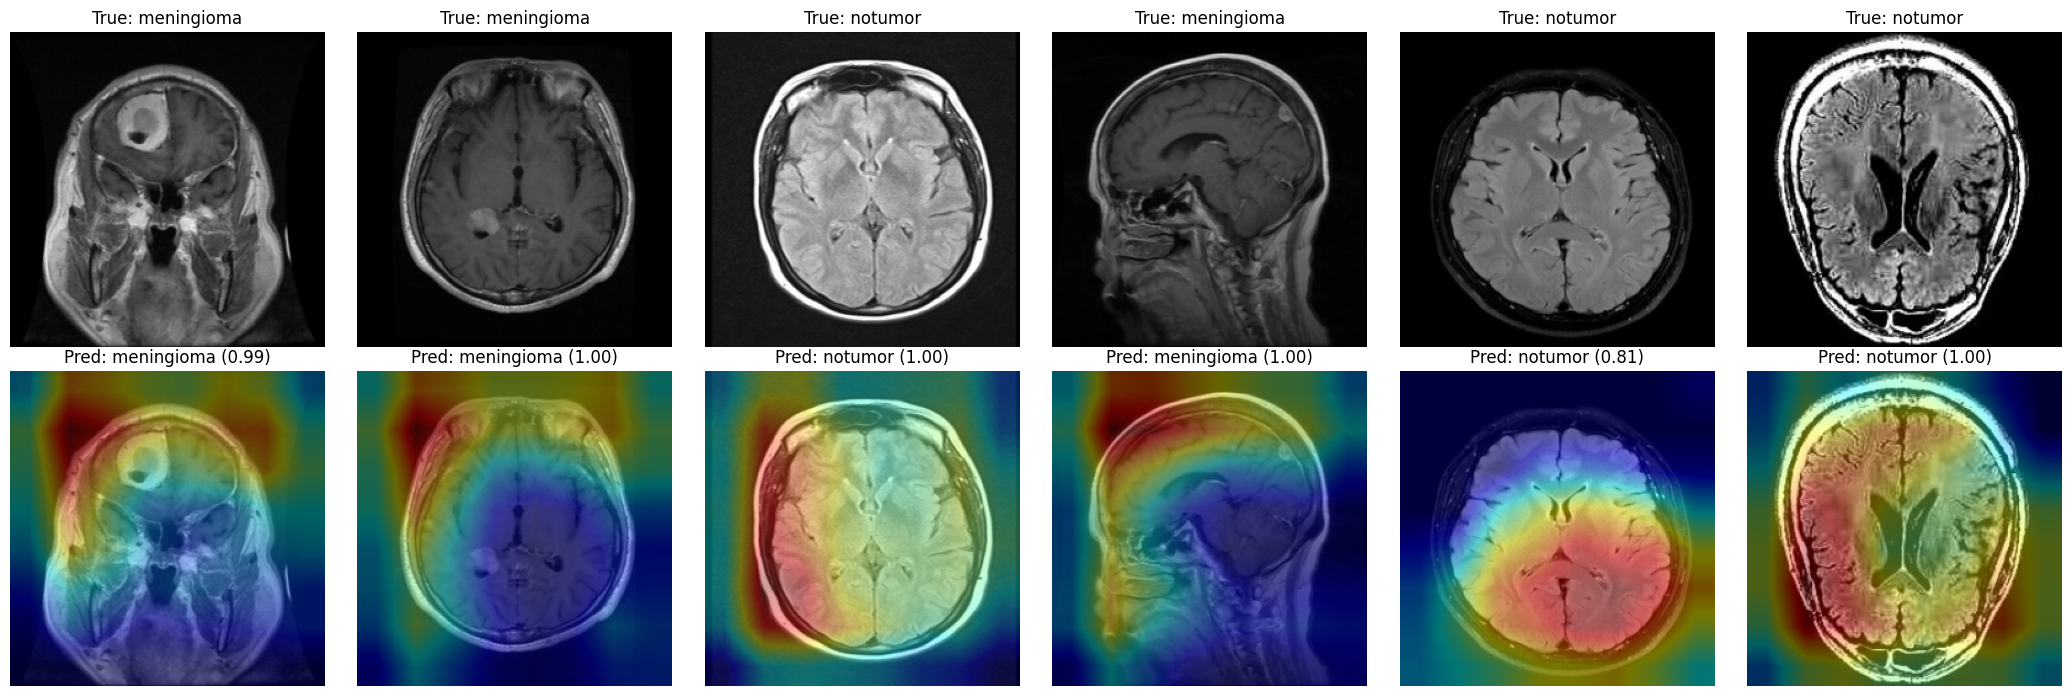

In [19]:
# Load a sample image from the test set
model.eval() # Ensure the classifier is in eval mode

# Instantiate GradCAM
# We need to target the last convolutional layer of the encoder within the classifier model
# For CustomResNet, the last convolutional layer before pooling is `model.layer4`
# If `add_attention` is True and you want to see the effect after attention, you could target `model.cbam4`.
# For general feature maps, `model.layer4` is a good choice.
target_layer_for_cam = model.layer4 # This is the crucial change for your model structure
grad_cam = GradCAM(model, target_layer_for_cam)

num_images_to_show = 6 # Number of random images to visualize

# --- MODIFICATION START ---
# Get random indices from the test_dataset
total_test_samples = len(test_dataset)
random_indices = random.sample(range(total_test_samples), num_images_to_show)

# Adjust figure size dynamically
# We'll plot two rows: Original Image and Superimposed CAM for predicted class
plt.figure(figsize=(num_images_to_show * 3.5, 7)) # Adjusted size for better display
# --- MODIFICATION END ---

for i, idx in enumerate(random_indices):
    # Retrieve the image and label using the random index from the dataset
    sample_data_transformed, true_label = test_dataset[idx] # This already has eval_transform applied

    # Add batch dimension and move to device
    sample_image = sample_data_transformed.unsqueeze(0).to(device)
    true_label_item = true_label # Label is already an int

    # Ensure the input image for Grad-CAM has requires_grad=True
    # Detach and clone is good practice to ensure it's a leaf variable for CAM
    sample_image_for_cam = sample_image.clone().detach().requires_grad_(True)

    # Get CAM (e.g., for predicted class)
    cam_output = grad_cam(sample_image_for_cam)

    # De-normalize and display the original image
    # The normalization was (x - 0.5) / 0.5, so reverse is x * 0.5 + 0.5
    original_image_display = (sample_image.squeeze().cpu().permute(1, 2, 0).numpy() * 0.5) + 0.5
    original_image_display = np.clip(original_image_display, 0, 1) # Clip to ensure valid RGB range

    # Overlay CAM on the original image
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_output), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1] # Convert BGR to RGB (OpenCV default is BGR)

    original_image_display_float = np.float32(original_image_display)

    # Superimpose the heatmap on the original image
    # You might want to experiment with the alpha blending factor
    alpha = 0.6 # Adjust transparency of heatmap
    superimposed_img = original_image_display_float + heatmap * alpha
    superimposed_img = superimposed_img / np.max(superimposed_img) # Normalize to prevent clipping (values > 1)
    superimposed_img = np.clip(superimposed_img, 0, 1) # Ensure values are within [0, 1]

    # Get predicted class and probability for display
    with torch.no_grad():
        # Make sure to use the correct model for prediction
        # model(sample_image) will output shape [1, 2] for num_classes=2
        output_logits = model(sample_image)

        # For binary classification with CrossEntropyLoss,
        # argmax gives the predicted class index (0 or 1)
        predicted_class_tensor = torch.argmax(output_logits, dim=1)
        predicted_class = predicted_class_tensor.item() # Now it's a single value, can use .item()

        # To get probability for the predicted class, apply softmax and get the value
        # For binary classification, often only the probability of class 1 is displayed
        probabilities = torch.softmax(output_logits, dim=1)
        # If you want the probability of the *predicted* class:
        predicted_prob = probabilities[0, predicted_class].item()
        # If you want the probability of class 1 (useful for binary display):
        # predicted_prob = probabilities[0, 1].item()


    # Plotting - Adjusted subplot indexing for random order
    plt.subplot(2, num_images_to_show, i + 1)
    plt.imshow(original_image_display)
    plt.title(f"True: {test_dataset.classes[true_label_item]}") # Display class name if available
    plt.axis('off')

    plt.subplot(2, num_images_to_show, i + 1 + num_images_to_show)
    plt.imshow(superimposed_img)
    # Use the predicted class name and its probability
    plt.title(f"Pred: {test_dataset.classes[predicted_class]} ({predicted_prob:.2f})") # Display class name and probability
    plt.axis('off')

plt.tight_layout()
plt.show()

# LIME

Processing Image 1/10: True Label: meningioma, Predicted Class: meningioma (Prob: 1.00)


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing Image 2/10: True Label: meningioma, Predicted Class: meningioma (Prob: 1.00)


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing Image 3/10: True Label: notumor, Predicted Class: notumor (Prob: 1.00)


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing Image 4/10: True Label: notumor, Predicted Class: notumor (Prob: 0.98)


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing Image 5/10: True Label: meningioma, Predicted Class: meningioma (Prob: 0.94)


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing Image 6/10: True Label: meningioma, Predicted Class: meningioma (Prob: 1.00)


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing Image 7/10: True Label: notumor, Predicted Class: notumor (Prob: 0.99)


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing Image 8/10: True Label: notumor, Predicted Class: notumor (Prob: 1.00)


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing Image 9/10: True Label: meningioma, Predicted Class: notumor (Prob: 0.89)


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing Image 10/10: True Label: notumor, Predicted Class: notumor (Prob: 1.00)


  0%|          | 0/1000 [00:00<?, ?it/s]

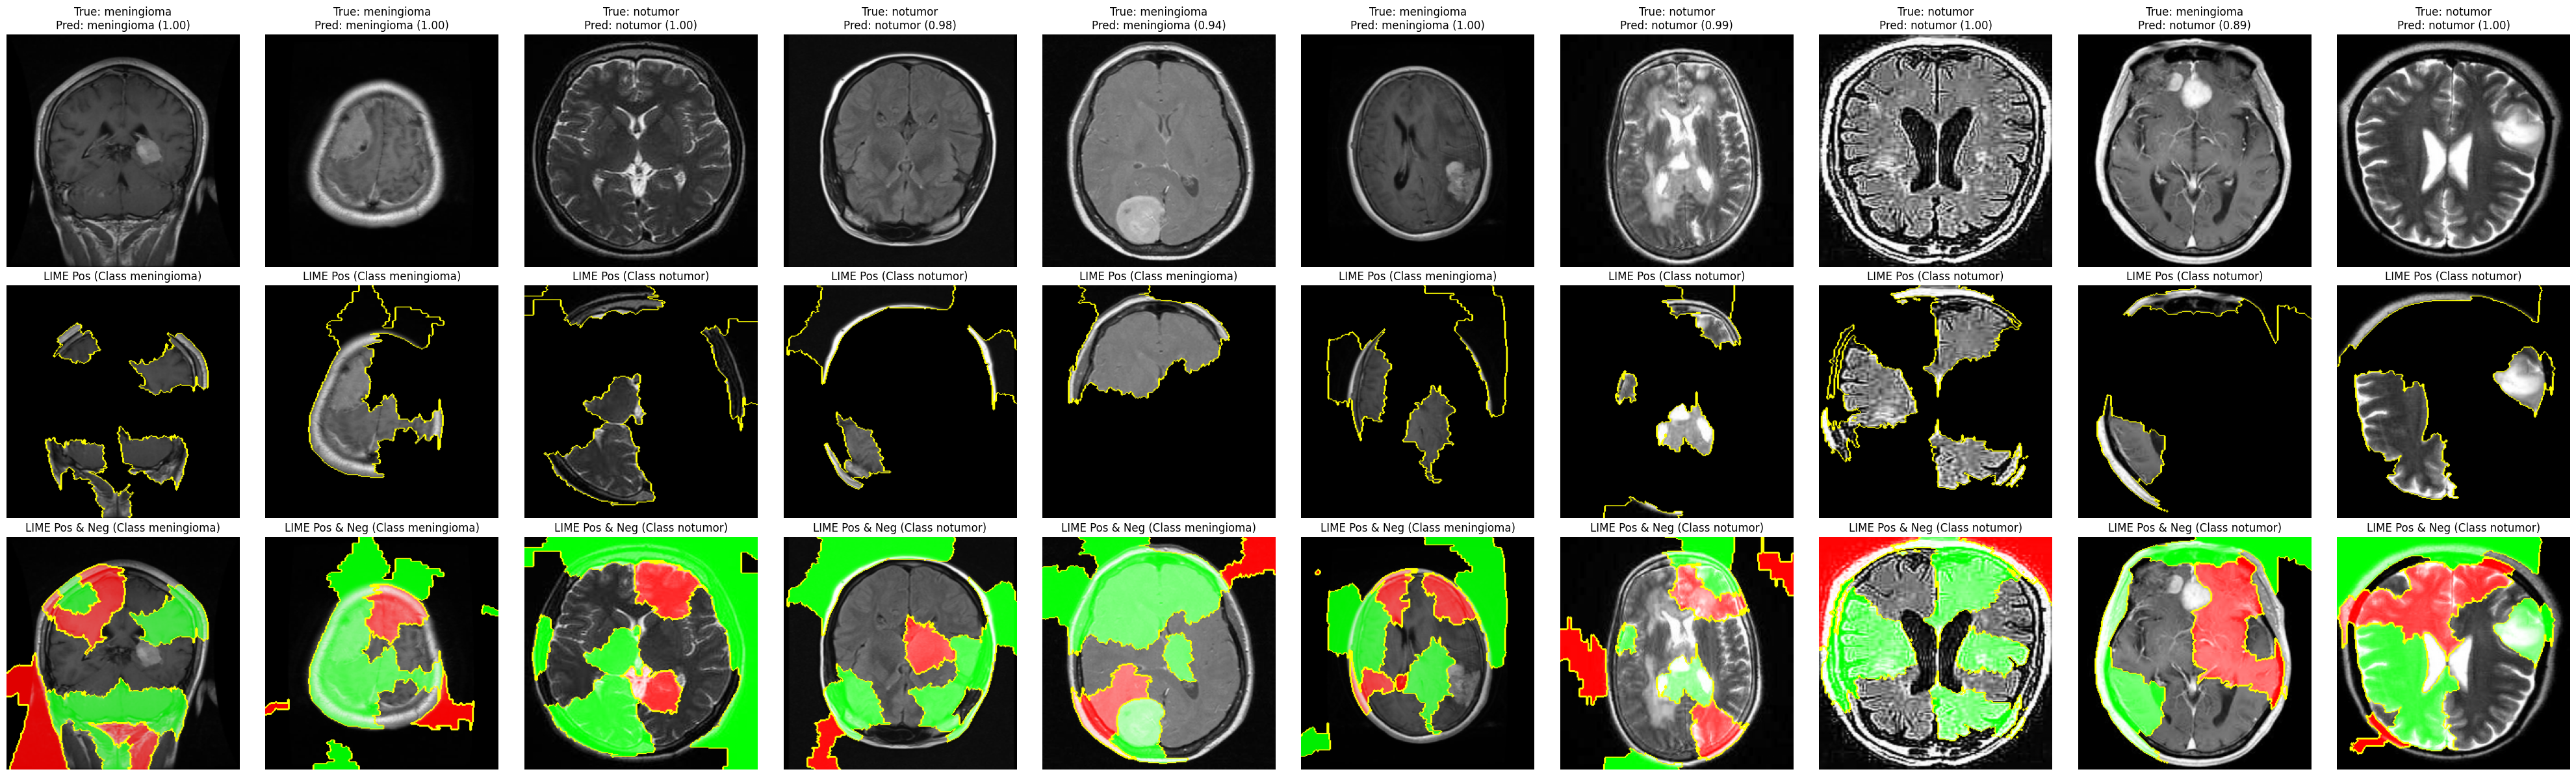


Finished LIME explanations for selected images.


In [21]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F # Import F

model.to(device) # Ensure the model (formerly classifier_model) is on device
model.eval()

# --- Define the prediction function for LIME ---
def predict_proba(images_np):
    """
    LIME needs a function that takes a NumPy array of images (already preprocessed)
    and returns a NumPy array of prediction probabilities for each class.

    Args:
        images_np (numpy.ndarray): A batch of images. Shape (N, H, W, C) where
                                    N is batch size, H/W are height/width, C is channels (RGB).
                                    LIME typically passes images in this format.

    Returns:
        numpy.ndarray: Prediction probabilities. Shape (N, 2) for binary classification
                        (probability of class 0, probability of Class 1).
    """
    # Convert NumPy array (H, W, C) to Torch tensor (C, H, W) and move to device
    # LIME passes (N, H, W, C) numpy array, so permute to (N, C, H, W)
    images_torch = torch.from_numpy(images_np).float().permute(0, 3, 1, 2)

    # Apply the same normalization used during training/evaluation
    # These values must match `transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])`
    # LIME images are 0-1, so de-normalize, then apply your model's normalization
    # The `original_image_for_lime` is denormalized to [0,1], then LIME adds noise.
    # So, `images_np` passed to `predict_proba` is in [0,1] range.
    # We need to apply the SAME normalization as your `eval_transform`.
    # Ensure mean and std are tensors on the correct device and shape
    mean = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1).to(images_torch.device)
    std = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1).to(images_torch.device)
    images_torch = (images_torch - mean) / std

    images_torch = images_torch.to(device)

    with torch.no_grad():
        outputs = model(images_torch) # Use 'model' directly
        # For binary classification with num_classes=2 and CrossEntropyLoss,
        # outputs shape is (batch_size, 2) containing logits for class 0 and class 1.
        # Apply softmax to get probabilities for both classes.
        probs = torch.softmax(outputs, dim=1)


    # LIME expects a (N, 2) array of probabilities [P(Class 0), P(Class 1)]
    return probs.cpu().numpy() # Shape (N, 2)


# --- LIME Explainer Initialization ---
# LIME explainer needs to know if the images are 0-1 or -1 to 1.
# Your original_image_for_lime is already denormalized to 0-1.
explainer = lime_image.LimeImageExplainer(random_state=42) # Added random_state for reproducibility

# --- Select images for both classes ---
num_images_per_class = 5

# Collect indices of each class
class0_indices = [i for i, (_, label) in enumerate(test_dataset) if label == 0]
class1_indices = [i for i, (_, label) in enumerate(test_dataset) if label == 1]

# Randomly sample desired number of images from each class
selected_indices_class0 = random.sample(class0_indices, min(num_images_per_class, len(class0_indices)))
selected_indices_class1 = random.sample(class1_indices, min(num_images_per_class, len(class1_indices)))

# Combine selected indices from both classes
all_selected_indices = selected_indices_class0 + selected_indices_class1
random.shuffle(all_selected_indices) # Shuffle to mix classes

# --- Adjust figure size ---
num_total_images = len(all_selected_indices)
plt.figure(figsize=(num_total_images * 4, 12)) # Adjusted size for better display: 3 rows, N images wide


# --- Loop through selected images and generate LIME explanations ---
for i, idx in enumerate(all_selected_indices):
    # Retrieve the image and label from the test_dataset (which has eval_transform applied)
    sample_data_transformed, true_label = test_dataset[idx]

    # Denormalize image for LIME's input and visualization
    # Original normalization was (x - 0.5) / 0.5. To reverse: x * 0.5 + 0.5
    original_image_for_lime = (sample_data_transformed.cpu().permute(1, 2, 0).numpy() * 0.5) + 0.5
    original_image_for_lime = np.clip(original_image_for_lime, 0, 1) # Ensure values are within [0, 1]

    # Get the model's prediction for this specific image
    with torch.no_grad():
        sample_image_input = sample_data_transformed.unsqueeze(0).to(device)
        # model(sample_image_input) returns logits [1, 2]
        output_logits = model(sample_image_input)

        # Get predicted class and its probability
        probabilities = torch.softmax(output_logits, dim=1)
        predicted_prob, predicted_class_tensor = torch.max(probabilities, dim=1) # Get max probability and its index

        predicted_class = predicted_class_tensor.item()
        predicted_prob_item = predicted_prob.item() # Use .item() on the single value tensor


    print(f"Processing Image {i+1}/{num_total_images}: True Label: {test_dataset.classes[true_label]}, Predicted Class: {test_dataset.classes[predicted_class]} (Prob: {predicted_prob_item:.2f})")

    # Generate LIME explanation for the predicted class
    explanation_class_to_explain = predicted_class

    explanation = explainer.explain_instance(
        original_image_for_lime,
        predict_proba,
        top_labels=1,
        hide_color=0, # Color to use for masked regions
        num_samples=1000 # Number of perturbed samples
    )

    # Get image and mask for positive contributions
    temp_pos, mask_pos = explanation.get_image_and_mask(
        explanation_class_to_explain,
        positive_only=True,
        num_features=5, # Number of superpixels to highlight
        hide_rest=True # Hide other superpixels
    )

    # Get image and mask for positive and negative contributions
    temp_neg, mask_neg = explanation.get_image_and_mask(
        explanation_class_to_explain,
        positive_only=False,
        num_features=10, # Number of superpixels to highlight (positive and negative)
        hide_rest=False # Show all superpixels, but highlight important ones
    )

    # --- Plotting for current image ---
    # `subplot` indexing: (num_rows, num_cols, current_index)
    # Rows = 3 (Original, Pos Only, Pos & Neg)
    # Cols = num_total_images (total number of images you are explaining)

    # Original Image
    plt.subplot(3, num_total_images, i + 1)
    plt.imshow(original_image_for_lime)
    plt.title(f"True: {test_dataset.classes[true_label]}\nPred: {test_dataset.classes[predicted_class]} ({predicted_prob_item:.2f})") # Use predicted_prob_item
    plt.axis('off')

    # LIME Explanation (Positive contributions only)
    plt.subplot(3, num_total_images, i + 1 + num_total_images)
    # `temp_pos` is already scaled correctly by LIME (often -1 to 1 or similar for coloring)
    # `mark_boundaries` will handle the color mapping internally based on the explanation.
    # The `temp_pos` and `temp_neg` images from `get_image_and_mask` are typically in a range
    # that `mark_boundaries` expects, often already re-centered around 0 for blending.
    # Removing `/ 2 + 0.5` which was for a different context.
    plt.imshow(mark_boundaries(temp_pos, mask_pos))
    plt.title(f"LIME Pos (Class {test_dataset.classes[explanation_class_to_explain]})")
    plt.axis('off')

    # LIME Explanation (Positive and Negative contributions)
    plt.subplot(3, num_total_images, i + 1 + 2 * num_total_images)
    plt.imshow(mark_boundaries(temp_neg, mask_neg))
    plt.title(f"LIME Pos & Neg (Class {test_dataset.classes[explanation_class_to_explain]})")
    plt.axis('off')

plt.tight_layout()
plt.show()

print("\nFinished LIME explanations for selected images.")

# SHAP

In [22]:
import shap # Make sure shap is imported

# --- Prepare background data for SHAP GradientExplainer ---
print("Preparing background data for SHAP...")
background_data = []
num_background_batches = 5 # Adjust based on available RAM and desired speed
for i, (images, _) in enumerate(train_loader):
    if i >= num_background_batches:
        break
    background_data.append(images)
background = torch.cat(background_data, dim=0).to(device)
print(f"Background data shape for SHAP: {background.shape}")

# Ensure the model is in evaluation mode
model.eval() # Use 'model' directly
# --- Initialize SHAP GradientExplainer ---
# Use 'model' as the classifier model
explainer = shap.GradientExplainer(model, background)
print("SHAP GradientExplainer initialized.")

# --- Select and Explain 5 random images per class ---
num_images_per_class = 5
class_names = test_dataset.classes # Get class names, e.g., ['class0', 'class1']
# If your classes are named differently or are not automatically inferred by ImageFolder,
# you might need to map them manually, e.g., class_names = {0: 'Benign', 1: 'Malignant'}

# Separate indices by class
class_indices = {i: [] for i in range(len(class_names))}
for idx, (_, label) in enumerate(test_dataset):
    class_indices[label].append(idx)

print(f"\nExplaining {num_images_per_class} random images per class...")

for class_label in sorted(class_indices.keys()):
    class_name = class_names[class_label]
    print(f"\n--- Explaining images for Class: '{class_name}' (Label: {class_label}) ---")

    # Randomly select N images from the current class's indices
    selected_indices = random.sample(class_indices[class_label], min(num_images_per_class, len(class_indices[class_label])))

    for i, idx in enumerate(selected_indices):
        print(f"Processing image {i+1}/{num_images_per_class} for class '{class_name}' (Test Dataset Index: {idx})...")

        # Get the image and its true label (already transformed by eval_transform)
        image_to_explain_tensor, true_label = test_dataset[idx]
        image_to_explain = image_to_explain_tensor.unsqueeze(0).to(device) # Add batch dimension and move to device

        # Get the model's prediction for the image
        with torch.no_grad():
            logit_prediction = model(image_to_explain).item() # Use 'model' directly
            predicted_probability = torch.sigmoid(torch.tensor(logit_prediction)).item()
            predicted_label = 1 if predicted_probability >= 0.5 else 0

        print(f"   Model raw logit prediction: {logit_prediction:.4f}")
        print(f"   Model predicted probability: {predicted_probability:.4f}")
        print(f"   Model predicted label: {predicted_label} ('{class_names[predicted_label]}')")

        # Compute SHAP values
        # shap_values will be a list of arrays (one for each model output).
        # Since your model has a single output, shap_values will be [numpy_array_of_shap_values]
        shap_values_raw = explainer.shap_values(image_to_explain)

        # For single output models, shap_values_raw[0] contains the actual SHAP values
        # for the current input. It will be (1, C, H, W) because of the batch dimension.
        # We need (C, H, W) for plotting.
        shap_values_for_plot = shap_values_raw[0][0] # Get rid of batch dimension

        # Unnormalize the image for plotting
        # Original transform was `transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])`
        # Reverse: x * std + mean
        img_unnormalized = (image_to_explain_tensor.cpu().numpy() * 0.5) + 0.5
        img_unnormalized = np.clip(img_unnormalized, 0, 1) # Clip to ensure valid RGB range
        # Reshape from (C, H, W) to (H, W, C) for matplotlib and shap.image_plot
        img_unnormalized = np.transpose(img_unnormalized, (1, 2, 0))

        # Display SHAP heatmap
        plt.figure(figsize=(8, 6)) # Create a new figure for each plot
        shap.image_plot(shap_values_for_plot, img_unnormalized,
                         labels=[f"True: {class_names[true_label]}", f"Predicted: {class_names[predicted_label]} (P={predicted_probability:.2f})"],
                         show=False) # show=False allows you to add suptitle before showing
        plt.suptitle(f"SHAP Explanation for Class '{class_name}' - Image {i+1}", fontsize=14)
        plt.show()

print("\nAll SHAP explanation processes complete for selected images.")

Preparing background data for SHAP...
Background data shape for SHAP: torch.Size([640, 3, 256, 256])


OutOfMemoryError: CUDA out of memory. Tried to allocate 640.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 398.12 MiB is free. Process 31968 has 14.35 GiB memory in use. Of the allocated memory 13.30 GiB is allocated by PyTorch, and 930.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Conformal Prediction

In [ ]:
model.to(device) # This line should already be present from previous CPU adaptation
model.eval() # Set model to evaluation mode

# --- 1. Data Split (Calibration and Final Test Sets) ---
# It's crucial that the calibration set has NOT been used for training.
# We'll split the existing 'test_dataset' into calibration and final test.
# Adjust these ratios as needed. A common split is 50/50 or 60/40 for test/calibration.
# For demonstration, let's use 50% for calibration and 50% for final test.
# Ensure you have enough samples in your test_dataset for this split.

calibration_ratio = 0.5 # Proportion of test_dataset to use for calibration
num_test_samples = len(test_dataset)
num_calibration_samples = int(calibration_ratio * num_test_samples)
num_final_test_samples = num_test_samples - num_calibration_samples

# Ensure reproducibility of the split
g = torch.Generator().manual_seed(42)

calibration_dataset, final_test_dataset = random_split(
    test_dataset,
    [num_calibration_samples, num_final_test_samples],
    generator=g # Use generator for reproducible split
)

calibration_loader = DataLoader(calibration_dataset, batch_size=32, shuffle=False)
final_test_loader = DataLoader(final_test_dataset, batch_size=32, shuffle=False)

print(f"Total test samples: {num_test_samples}")
print(f"Calibration samples: {len(calibration_dataset)}")
print(f"Final test samples: {len(final_test_dataset)}")

In [ ]:
# --- 2. Calibration Phase: Calculate Nonconformity Scores ---
nonconformity_scores = []

print("\nRunning calibration phase...")
with torch.no_grad():
    for images, labels in calibration_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Use 'model' directly
        logits = model(images).squeeze(1) # Output is [batch_size, 1], squeeze to [batch_size]
        probs_class1 = torch.sigmoid(logits) # P(Class=1)

        # Calculate nonconformity scores: 1 - P(true_class)
        # If true_label is 0, score = P(Class=1)
        # If true_label is 1, score = 1 - P(Class=1)

        # Combine using torch.where for efficiency
        # scores = torch.where(condition, value_if_true, value_if_false)
        scores_batch = torch.where(
            labels == 0,         # condition: if true label is 0
            probs_class1,        # score is P(Class=1)
            1 - probs_class1     # else (true label is 1), score is 1 - P(Class=1)
        )
        nonconformity_scores.extend(scores_batch.cpu().numpy())

# Convert to numpy array and sort
nonconformity_scores = np.array(nonconformity_scores)
nonconformity_scores.sort()

# --- 3. Determine the Conformal Quantile (q-hat) ---
# Set desired significance level (alpha)
alpha = 0.10 # This means 90% coverage is desired (1 - alpha)

# Calculate the quantile index.
# The formula is ceiling((n+1)(1-alpha)) / n for (n+1) nonconformity scores if doing exact
# For sorted scores, it's (n+1) * (1-alpha)th value.
# The standard formula for finite sample correction for non-parametric conformal inference is:
# q_hat = (N+1) * (1-alpha)th smallest nonconformity score.
# In Python/Numpy, this often translates to index ceil((N+1)*(1-alpha)) - 1
# This ensures a coverage guarantee of at least 1-alpha.

n_calibration = len(nonconformity_scores)
q_hat_index = int(np.ceil((n_calibration + 1) * (1 - alpha))) - 1

# Handle edge cases for q_hat_index (e.g., if alpha is too small or too large)
if q_hat_index < 0:
    q_hat = nonconformity_scores[0]
elif q_hat_index >= n_calibration:
    q_hat = nonconformity_scores[-1]
else:
    q_hat = nonconformity_scores[q_hat_index]

print(f"\nCalibration complete. q_hat (nonconformity threshold) for alpha={alpha}: {q_hat:.4f}")
print(f"Number of calibration samples: {n_calibration}")
print(f"Index used for q_hat: {q_hat_index}")
print(f"Desired coverage: {1 - alpha}")

In [ ]:
# --- 4. Prediction Phase: Generate Prediction Sets for New Test Data ---
correct_coverage_count = 0
total_samples = 0
total_set_size = 0

# --- NEW: Lists to collect data for plots ---
all_set_sizes = [] # For Plot 2: Prediction Set Size Distribution
max_probs = []     # For Plot 3: Confidence vs. Set Size
# --------------------------------------------

print("\nRunning prediction phase on final test set...")
print("-" * 50)
print(f"{'Sample':<10} | {'True Label':<12} | {'Predicted Prob(1)':<18} | {'Pred Set':<15} | {'Coverage':<10} | {'Set Size':<10}")
print("-" * 50)

with torch.no_grad():
    for i, (images, labels) in enumerate(final_test_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Use 'model' directly
        logits = model(images).squeeze(1)
        probs_class1 = torch.sigmoid(logits) # P(Class=1)

        for j in range(images.size(0)):
            true_label = labels[j].item()
            prob_class1 = probs_class1[j].item()

            # Calculate hypothetical nonconformity scores for each class
            # Score for class 0 (assuming 0 is true) = P(Class=1)
            # Score for class 1 (assuming 1 is true) = 1 - P(Class=1)
            score_if_0 = prob_class1
            score_if_1 = 1 - prob_class1

            prediction_set = []
            if score_if_0 <= q_hat:
                prediction_set.append(0)
            if score_if_1 <= q_hat:
                prediction_set.append(1)

            # Check for coverage
            is_covered = (true_label in prediction_set)
            if is_covered:
                correct_coverage_count += 1

            total_samples += 1
            total_set_size += len(prediction_set)

            # --- NEW: Collect data for plots ---
            all_set_sizes.append(len(prediction_set))
            # Model's confidence is the probability of the class it 'prefers'
            # (i.e., max(P(Class=0), P(Class=1)))
            max_probs.append(max(prob_class1, 1 - prob_class1))
            # ------------------------------------

            # Print results for a few samples for demonstration
            if total_samples <= 20: # Print first 20 for brevity
                print(f"{total_samples:<10} | {true_label:<12} | {prob_class1:<18.4f} | {str(prediction_set):<15} | {str(is_covered):<10} | {len(prediction_set):<10}")

print("-" * 50)

In [ ]:
# --- 5. Evaluation of Conformal Prediction ---
empirical_coverage = correct_coverage_count / total_samples
average_set_size = total_set_size / total_samples

print(f"\nConformal Prediction Results:")
print(f"Total samples in final test set: {total_samples}")
print(f"Empirical Coverage: {empirical_coverage:.4f} (Expected: >= {1 - alpha})")
print(f"Average Prediction Set Size: {average_set_size:.4f}")

# Example of what average set size means:
if average_set_size == 1.0:
    print("Most predictions are single-class sets (high confidence).")
elif average_set_size > 1.0 and average_set_size < 2.0:
    print("Many predictions are single-class, but some are two-class sets (uncertain).")
elif average_set_size == 2.0:
    print("All predictions are two-class sets (model is highly uncertain or q_hat is too high).")


# --- 6. Plotting Results ---

# Plot 1: Empirical Coverage vs. Desired Coverage for various alpha
alphas_for_plot = np.linspace(0.01, 0.5, 20) # Test a range of alpha values from 1% to 50%
empirical_coverages_for_plot = []
desired_coverages_for_plot = []

print("\nCalculating empirical coverages for various alpha values...")
for current_alpha in alphas_for_plot:
    # Recalculate q_hat for the current alpha
    q_hat_loop_index = int(np.ceil((n_calibration + 1) * (1 - current_alpha))) - 1
    if q_hat_loop_index < 0:
        q_hat_loop = nonconformity_scores[0]
    elif q_hat_loop_index >= n_calibration:
        q_hat_loop = nonconformity_scores[-1]
    else:
        q_hat_loop = nonconformity_scores[q_hat_loop_index]

    current_correct_coverage_count = 0
    current_total_samples = 0

    with torch.no_grad():
        for images, labels in final_test_loader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images).squeeze(1) # Use 'model'
            probs_class1 = torch.sigmoid(logits)

            for j in range(images.size(0)):
                true_label = labels[j].item()
                prob_class1 = probs_class1[j].item()

                score_if_0 = prob_class1
                score_if_1 = 1 - prob_class1

                prediction_set = []
                if score_if_0 <= q_hat_loop: # Use q_hat_loop for current alpha
                    prediction_set.append(0)
                if score_if_1 <= q_hat_loop:
                    prediction_set.append(1)

                is_covered = (true_label in prediction_set)
                if is_covered:
                    current_correct_coverage_count += 1
                current_total_samples += 1

    empirical_coverages_for_plot.append(current_correct_coverage_count / current_total_samples)
    desired_coverages_for_plot.append(1 - current_alpha)

plt.figure(figsize=(8, 6))
plt.plot(desired_coverages_for_plot, empirical_coverages_for_plot, marker='o', linestyle='-', label='Empirical Coverage')
plt.plot(desired_coverages_for_plot, desired_coverages_for_plot, color='red', linestyle='--', label='Desired Coverage (1-alpha)')
plt.title('Empirical Coverage vs. Desired Coverage')
plt.xlabel('Desired Coverage (1 - alpha)')
plt.ylabel('Empirical Coverage')
plt.grid(True)
plt.legend()
plt.ylim(0, 1.05)
plt.xlim(0, 1.05)
plt.show()

In [ ]:
plt.figure(figsize=(7, 5))
plt.hist(all_set_sizes, bins=[0.5, 1.5, 2.5], rwidth=0.8, align='mid', edgecolor='black')
plt.xticks([1, 2], ['Size 1 (Single Class)', 'Size 2 (Two Classes)'])
plt.title('Distribution of Prediction Set Sizes')
plt.xlabel('Prediction Set Size')
plt.ylabel('Number of Samples')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Plot 3: Scatter plot of Max Probability vs. Prediction Set Size
plt.figure(figsize=(8, 6))
plt.scatter(max_probs, all_set_sizes, alpha=0.5)
plt.title('Model Confidence (Max Prob) vs. Prediction Set Size')
plt.xlabel('Max Predicted Probability (Confidence)')
plt.ylabel('Prediction Set Size')
plt.yticks([1, 2]) # Only 1 or 2
plt.grid(True)
plt.show()

print("\nConformal Prediction analysis complete.")